In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import os
os.getcwd()




'c:\\Users\\sarthak\\Desktop\\i\\devsoc_\\SentimentAnalysisCrypto'

In [8]:
# Load sentiment data
sentiment_df = pd.read_csv("lst_price/final_perday_bt.csv")
sentiment_df.rename(columns={"date": "Date"}, inplace=True)
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])

twitter_df = pd.read_csv("lst_price/final_perday_bt_twitter.csv")
twitter_df.rename(columns={"date": "Date"}, inplace=True)
twitter_df["Date"] = pd.to_datetime(twitter_df["Date"])
# sentiment_df = pd.merge(sentiment_df, twitter_df, on="Date", how="inner")

# Load price data
price_df = pd.read_csv("lst_price/BTCUSDT_closing.csv")
price_df.rename(columns={"Open Time": "Date", "Close": "Close_Price"}, inplace=True)
price_df["Date"] = pd.to_datetime(price_df["Date"])



# Merge on Date
merged_df = pd.merge(sentiment_df, price_df, on="Date", how="inner")
merged_df.sort_values("Date", inplace=True)

# Reset index for modeling
merged_df.reset_index(drop=True, inplace=True)

# Add nextday_price_ratio column: next day's price divided by today's price
merged_df['change_pct'] = (merged_df['Close_Price'].shift(-1) -merged_df['Close_Price']) / merged_df['Close_Price']

merged_df

,Date,compound,Close_Price,change_pct
0,2021-11-05,0.265660,60873.95,0.004880
1,2021-11-06,0.000000,61171.04,0.062589
2,2021-11-08,-0.223925,64999.68,0.040056
3,2021-11-09,0.264050,67603.30,-0.008971
4,2021-11-10,0.308225,66996.82,-0.030681
...,...,...,...,...
1374,2025-08-29,0.069189,112200.94,-0.034761
1375,2025-08-30,0.067619,108300.71,0.010050
1376,2025-08-31,0.160374,109389.08,-0.010666
1377,2025-09-01,0.233910,108222.37,0.007558


In [9]:
# --- Feature Preparation with Date-based Train-Test Split (Current Price as Feature) ---
from sklearn.preprocessing import StandardScaler

SEQ_LEN = 30 # Number of past days to use
features = []
targets = []
dates = []
target2 = []

for i in range(SEQ_LEN, len(merged_df)):
    past_sentiment = merged_df['compound'].values[i-SEQ_LEN:i]
    past_price = merged_df['change_pct'].values[i-SEQ_LEN:i]
    current_sentiment = merged_df['compound'].values[i]
    current_price = merged_df['Close_Price'].values[i]
    x = np.concatenate([past_sentiment, past_price, [current_sentiment]])
    features.append(x)
    # Target is next day's price change percentage
    if i + 1 < len(merged_df):
        next_price = merged_df['Close_Price'].values[i + 1]
        change_pct = (next_price - current_price) /current_price 
        targets.append(change_pct)
        target2.append(next_price)
        dates.append(merged_df['Date'].values[i + 1])

# Remove last feature if it doesn't have a corresponding target
dates = np.array(dates)
if len(features) > len(targets):
    features = features[: len(targets)]
    dates = dates[: len(targets)]

features = np.array(features)
targets = np.array(targets)

# Date-based split
split_date = np.datetime64('2024-11-10')
train_idx = dates < split_date
test_idx = dates >= split_date

X_train = features[train_idx]
X_test = features[test_idx]
y_train = targets[train_idx]
y_test = targets[test_idx]

actual_prices = np.array(target2)
y_test_prices = actual_prices[test_idx]
# Normalize features and targets
# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_test = scaler_X.transform(X_test)
# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
# y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [10]:

# --- LSTM Model Definition ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last output
        out = self.fc(out)
        return out


input_size = X_train.shape[1]
hidden_size = 32
model = LSTMModel(input_size=input_size, hidden_size=hidden_size)


In [11]:
# --- Training Loop (Train on Train Data) ---
input_size = X_train_tensor.shape[1]
hidden_size = 32
model = LSTMModel(input_size=input_size, hidden_size=hidden_size)

epochs = 3000
lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Reshape for LSTM: (batch, seq_len=1, input_size)
X_train_lstm = X_train_tensor.unsqueeze(1)
X_test_lstm = X_test_tensor.unsqueeze(1)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_lstm)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/4000, Loss: 0.0105
Epoch 20/4000, Loss: 0.0104
Epoch 30/4000, Loss: 0.0103
Epoch 40/4000, Loss: 0.0103
Epoch 50/4000, Loss: 0.0102
Epoch 60/4000, Loss: 0.0101
Epoch 70/4000, Loss: 0.0101
Epoch 80/4000, Loss: 0.0100
Epoch 90/4000, Loss: 0.0099
Epoch 100/4000, Loss: 0.0099
Epoch 110/4000, Loss: 0.0098
Epoch 120/4000, Loss: 0.0097
Epoch 130/4000, Loss: 0.0096
Epoch 140/4000, Loss: 0.0096
Epoch 150/4000, Loss: 0.0095
Epoch 160/4000, Loss: 0.0095
Epoch 170/4000, Loss: 0.0094
Epoch 180/4000, Loss: 0.0093
Epoch 190/4000, Loss: 0.0093
Epoch 200/4000, Loss: 0.0092
Epoch 210/4000, Loss: 0.0091
Epoch 220/4000, Loss: 0.0091
Epoch 230/4000, Loss: 0.0090
Epoch 240/4000, Loss: 0.0089
Epoch 250/4000, Loss: 0.0089
Epoch 260/4000, Loss: 0.0088
Epoch 270/4000, Loss: 0.0087
Epoch 280/4000, Loss: 0.0087
Epoch 290/4000, Loss: 0.0086
Epoch 300/4000, Loss: 0.0086
Epoch 310/4000, Loss: 0.0085
Epoch 320/4000, Loss: 0.0084
Epoch 330/4000, Loss: 0.0084
Epoch 340/4000, Loss: 0.0083
Epoch 350/4000, Loss: 0

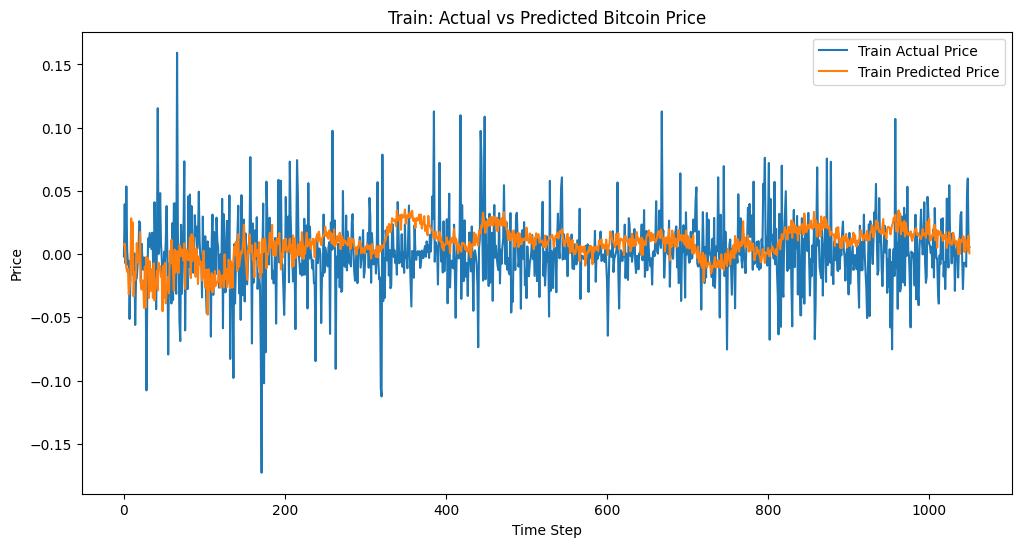

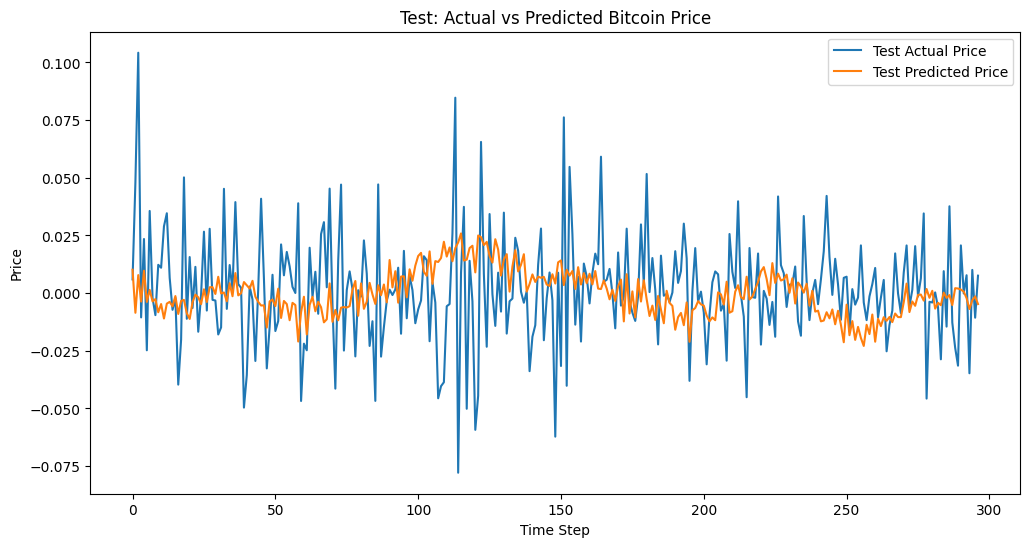

In [12]:
# Evaluate model predictions vs actual values for train and test
model.eval()
with torch.no_grad():
    # Train predictions
    train_pred_norm = model(X_train_lstm).squeeze().numpy()
    train_actual_norm = y_train_tensor.squeeze().numpy()
    # train_pred = scaler_y.inverse_transform(train_pred_norm.reshape(-1, 1)).flatten()
    # train_actual = scaler_y.inverse_transform(train_actual_norm.reshape(-1, 1)).flatten()
    # Test predictions
    test_pred_norm = model(X_test_lstm).squeeze().numpy()
    test_actual_norm = y_test_tensor.squeeze().numpy()
    # test_pred = scaler_y.inverse_transform(test_pred_norm.reshape(-1, 1)).flatten()
    # test_actual = scaler_y.inverse_transform(test_actual_norm.reshape(-1, 1)).flatten()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(train_actual_norm, label='Train Actual Price')
plt.plot(train_pred_norm, label='Train Predicted Price')
plt.title('Train: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_actual_norm, label='Test Actual Price')
plt.plot(test_pred_norm, label='Test Predicted Price')
plt.title('Test: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

# # Optionally, print sample values
# print('First 10 Train Actual:', train_actual_norm[:10])
# print('First 10 Train Predicted:', train_pred_norm[:10])
# print('First 10 Test Actual:', test_actual_norm[:10])
# print('First 10 Test Predicted:', test_pred_norm[:10])

In [13]:
class ThresholdTradingAlgo:
    def __init__(self, threshold=100.0, initial_balance=10000):
        self.threshold = threshold
        self.balance = initial_balance   # cash
        self.btc_holdings = 0.0          # how much BTC you own (positive = long, negative = short liability)
        self.position = 0                # +1 long, -1 short, 0 flat
        self.trade_history = []

    def step(self, current_price, predicted_change):
        diff = predicted_change*current_price

        # --- BUY signal ---
        if predicted_change > self.threshold and self.position <= 0:
            # If short, close it first
            if self.position == -1:
                # Buy back BTC to close short
                cost_to_close = abs(self.btc_holdings) * current_price
                self.balance -= cost_to_close
                self.btc_holdings = 0
                self.trade_history.append(("CLOSE SHORT", current_price))

            # Go long with all balance
            btc_to_buy = self.balance / current_price
            self.btc_holdings = btc_to_buy
            self.balance = 0
            self.position = 1
            self.trade_history.append(("BUY", current_price))

        # --- SELL signal ---
        elif predicted_change < -self.threshold and self.position >= 0:
            # If long, close it first
            if self.position == 1:
                self.balance += self.btc_holdings * current_price
                self.btc_holdings = 0
                self.trade_history.append(("CLOSE LONG", current_price))

            # Go short: borrow BTC & sell immediately
            btc_to_short = self.balance / current_price
            self.btc_holdings = -btc_to_short
            self.balance += btc_to_short * current_price
            self.position = -1
            self.trade_history.append(("SELL SHORT", current_price))

        else:
            self.trade_history.append(("HOLD", current_price))

    def get_portfolio_value(self, current_price):
        # Cash + (long BTC value or negative liability for short BTC)
        return self.balance + self.btc_holdings * current_price


In [14]:
algo = ThresholdTradingAlgo(threshold=0.005, initial_balance=10000)

for today_price, pred_price in zip(actual_prices, np.roll(train_pred_norm, -1)):
    algo.step(today_price, pred_price)
    print("Portfolio Value:", algo.get_portfolio_value(today_price), " History: ", algo.trade_history[-1], " Prediction: ", pred_price, "actual: ", today_price)


Portfolio Value: 10000.0  History:  ('BUY', np.float64(46793.23))  Prediction:  0.008284509 actual:  46793.23
Portfolio Value: 10395.548672318622  History:  ('HOLD', np.float64(48644.13))  Prediction:  -0.0034387633 actual:  48644.13
Portfolio Value: 10319.868921209329  History:  ('SELL SHORT', np.float64(48290.0))  Prediction:  -0.010742582 actual:  48290.0
Portfolio Value: 9766.929959739902  History:  ('HOLD', np.float64(50877.38))  Prediction:  -0.013978191 actual:  50877.38
Portfolio Value: 9731.05511203223  History:  ('HOLD', np.float64(51045.25))  Prediction:  -0.011554129 actual:  51045.25
Portfolio Value: 9821.320306377653  History:  ('HOLD', np.float64(50622.87))  Prediction:  -0.031624638 actual:  50622.87
Portfolio Value: 9879.585145116076  History:  ('HOLD', np.float64(50350.23))  Prediction:  -0.026487105 actual:  50350.23
Portfolio Value: 10430.97046303493  History:  ('HOLD', np.float64(47770.12))  Prediction:  -0.020652197 actual:  47770.12
Portfolio Value: 10661.1362370

In [15]:
train_pred_norm

array([ 0.00746585,  0.00828451, -0.00343876, ...,  0.00221149,
        0.01464947,  0.00064591], dtype=float32)

In [16]:
train_actual_norm

array([-0.00186857,  0.03955487, -0.00728001, ...,  0.05982105,
        0.0087084 ,  0.00558843], dtype=float32)

In [1]:
algo.trade_history

NameError: name 'algo' is not defined